In [1]:
! git clone https://github.com/avikskr/hand_writing_VAE.git

Cloning into 'hand_writing_VAE'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 835 (delta 0), reused 36 (delta 0), pack-reused 799
Receiving objects: 100% (835/835), 27.73 MiB | 30.93 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (2597/2597), done.


In [0]:
'''Example of VAE on MNIST dataset using MLP

The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to  generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean=0 and std=1.

# Reference

[1] Kingma, Diederik P., and Max Welling.
"Auto-encoding variational bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import cv2
import imutils
from imutils import paths

plt.style.use('classic')

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel(z[0])
    plt.ylabel(z[1])
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


# MNIST dataset
'''print('loading MNIST data')
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255'''

#handwriting image

#input = 'F://AR//python//handwriting//train'
input='hand_writing_VAE/train'

imagepaths = os.listdir(input)
count = {}

img_data_list=[]
for (i, imgpath) in enumerate(imagepaths):
    #print("processing image {}/{}".format(i + 1, len(imagepaths)))
    imgpathfull=input+"//"+imgpath
    #print("imgpath:", imgpathfull)

    #image=cv2.imread(imgpathfull)
    #print(image.shape)
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #print(gray.shape)
    gray=cv2.imread(imgpathfull,0)
    gray=cv2.resize(gray,(28,28),interpolation=cv2.INTER_AREA)
    #print(gray.shape)
    img_data_list.append(gray)

x_train=np.array(img_data_list)
print('x_train shape',x_train.shape)

#input = 'F://AR//python//handwriting//test_bd'
input='hand_writing_VAE/Segment/Characters/binary_segment'
imagepaths = os.listdir(input)

labels=[]
img_data_list=[]
count = 0
for imgpath in paths.list_images(input):
    #print(imgpath)
    #print("processing image {}/{}".format(i + 1, len(imagepaths)))
    #imgpathfull=os.path.join(input,imgpath)
    #imgpathfull=input+"//"+imgpath
    #print("imgpath:", imgpathfull)

    #image=cv2.imread(imgpath)
    #print(image)
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray=cv2.imread(imgpath,0)
    #print(gray.shape)
    gray=cv2.resize(gray,(28,28),interpolation=cv2.INTER_AREA)
    #print(gray.shape)
    img_data_list.append(gray)

    label=imgpath.split(os.path.sep)[-2]
    labels.append(label)
    count+=1

x_test=np.array(img_data_list)
#print('x_test shape',x_test.shape)

image_size = x_train.shape[1]
original_dim = image_size * image_size

x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
#x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
#x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
#print ('x_train final shape: ',x_train.shape)
#print ('x_test final shape: ',x_test.shape)

y_test=np.array(labels)
y_test=y_test.astype('float32')/count
#y_test=y_test.reshape(y_test.shape[1],)
print(y_test.shape)



x_train shape (1051, 28, 28)
(439,)


x_train:  (1051, 784)  x_test:  (439, 784)  labels:  (439,)
build VAE
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_16[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_16[0][0]                   
_______________________________________

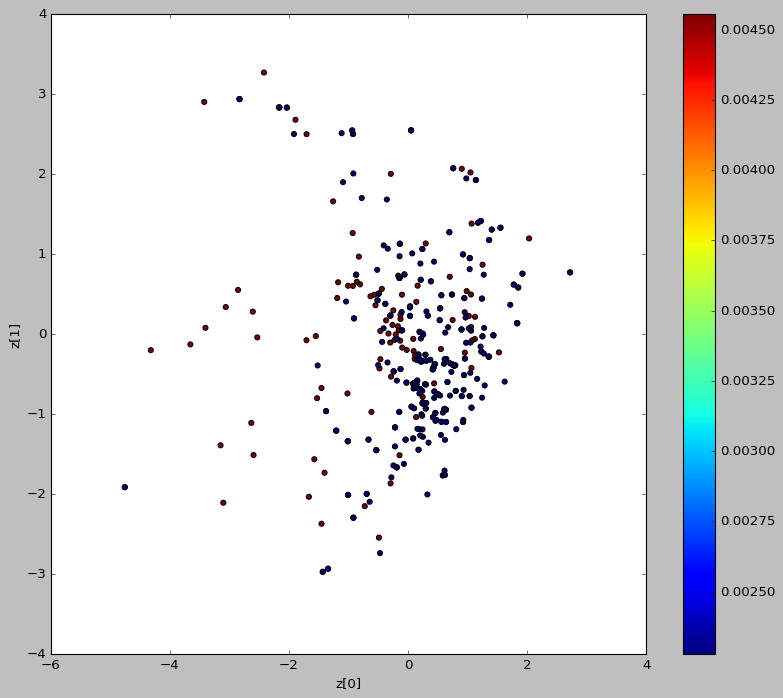

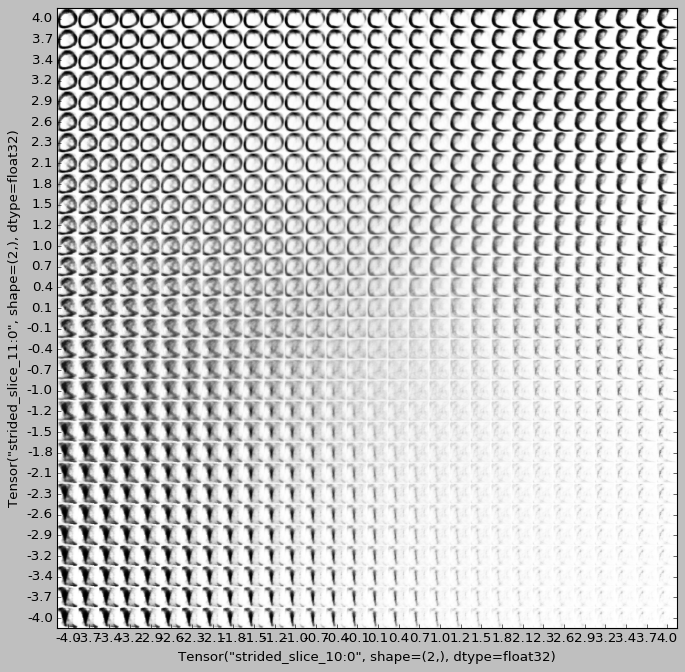

In [0]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50
print('x_train: ',x_train.shape,' x_test: ',x_test.shape,' labels: ',y_test.shape)
# VAE model = encoder + decoder
# build encoder model
print('build VAE')
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
print('Encoder+Decoder')
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
print('Instantiating the model')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
print('Instantiated VAE')
'''if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    help_ = "Load h5 model trained weights"
    parser.add_argument("-w", "--weights", help=help_)
    help_ = "Use mse loss instead of binary cross entropy (default)"
    parser.add_argument("-m",
                        "--mse",
                        help=help_, action='store_true')
    args = parser.parse_args()
    models = (encoder, decoder)
    data = (x_test, y_test)

    # VAE loss = mse_loss or xent_loss + kl_loss
    if args.mse:
        reconstruction_loss = mse(inputs, outputs)
    else:
        reconstruction_loss = binary_crossentropy(inputs,
                                                  outputs)'''
models = (encoder, decoder)

data = (x_test, y_test)
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
print('Instantiate VAE')
#plot_model(vae,to_file='vae_mlp.png',show_shapes=True)

# train the autoencoder
print('train the autoencoder')
vae.fit(x_train,
epochs=epochs,
batch_size=batch_size,
validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')

plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")


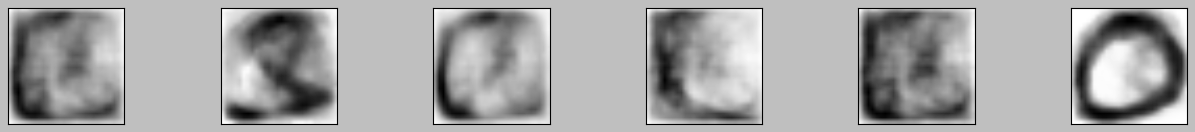

In [0]:
#encoded_imgs = encoder.predict(x_test)
#decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs = vae.predict(x_test)
#print(encoded_imgs.shape,' ',decoded_imgs.shape)

import matplotlib.pyplot as plt

n = 6  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original
    '''ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)'''

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()